The Following reads the FASTA file, and displays information on it

In [64]:
import os
from Bio import SeqIO

# Folder containing the unzipped FASTA files
folder_path = "./unzipped_mt_datasets/"

# List to store genome IDs with full species names
genomes = []

# Extract full header information for clarity
for root, dirs, files in os.walk(folder_path):
    for filename in files:
        if filename.endswith(".fa") or filename.endswith(".fas"):
            file_path = os.path.join(root, filename)
            record = next(SeqIO.parse(file_path, "fasta"))
            # Store the file name with folder name as prefix and actual sequence
            prefixed_filename = os.path.join(os.path.basename(root), filename)
            genomes.append((prefixed_filename, str(record.seq)))  # Include the sequence as a string

# Print the loaded genomes to verify
print(f"Loaded genomes:")
for genome_id in genomes:
    print(genome_id[0])


Loaded genomes:
Amphibian\Leptobrachium_leishanense.ASM966780v1.dna.nonchromosomal.fa
Aves\Gallus_gallus_gca016700215v2.bGalGal1.pat.whiteleghornlayer.GRCg7w.dna.nonchromosomal.fa
Bacteria\GCF_000012365.1.fas
Bacteria\GCF_004004565.1.fas
Bacteria\GCF_004125865.1.fas
Bacteria\GCF_004216565.1.fas
Bacteria\GCF_900101795.1.fas
Bacteria\GCF_900102625.1.fas
Bacteria\GCF_900230245.1.fas
Bacteria\GCF_900240305.1.fas
Bacteria\GCF_900249725.1.fas
Bacteria\GCF_900249745.1.fas
Bacteria\GCF_900249755.1.fas
Bacteria\GCF_900249795.1.fas
Bacteria\GCF_900249855.1.fas
Bacteria\GCF_900249995.1.fas
Bacteria\GCF_900250075.1.fas
Bacteria\GCF_900250125.1.fas
Bacteria\GCF_900258035.1.fas
Bacteria\GCF_900454285.1.fas
Bacteria\GCF_900454575.1.fas
Bacteria\GCF_900606115.1.fas
Bacteria\GCF_900637555.1.fas
Mammal\Mus_musculus.GRCm39.dna.chromosome.MT.fa
Mammal\Sus_scrofa.Sscrofa11.1.dna.nonchromosomal.fa
Pisces\AB054124.fas
Pisces\AP011198.fas
Pisces\AP011199.fas
Pisces\AP011200.fas
Pisces\AP011332.fas
Pisces\AP01

splits the sequence into 6-mers and displays a sample

In [110]:
from collections import Counter

def k_mer_count(sequence, k=4):
    """Counts k-mers in the sequence."""
    return Counter([sequence[i:i + k] for i in range(len(sequence) - k + 1)])

# Generate k-mer counts for each genome
kmer_vectors = []
k = 4  # Define k value
for genome_id, sequence in genomes:
    if len(sequence) >= k:  # Only process sequences long enough for k-mers
        kmer_counts = k_mer_count(sequence, k=k)
        kmer_vectors.append(kmer_counts)
    else:
        kmer_vectors.append(Counter())  # Add an empty Counter for short sequences

# Print a single example at the end
if kmer_vectors:
    first_non_empty = next((kv for kv in kmer_vectors if kv), None)  # Find the first non-empty Counter
    if first_non_empty:
        print(f"Sample 9-mer counts: {list(first_non_empty.items())[:10]}")
    else:
        print("No valid k-mers found in the data.")
else:
    print("No data to process.")


Sample 9-mer counts: [('ACTC', 2252), ('CTCT', 3852), ('TCTC', 3400), ('CTCA', 3050), ('TCAT', 3586), ('CATC', 2952), ('ATCA', 3534), ('TCAA', 3300), ('CAAC', 2501), ('AACG', 1534)]


transforming the k-mer count into a feature vector for clustering

In [111]:
from sklearn.feature_extraction import DictVectorizer

# Convert the k-mer dictionaries to numerical vectors
vectorizer = DictVectorizer(sparse=False)
X = vectorizer.fit_transform(kmer_vectors)

print(f"Feature Vector Shape: {X.shape}")



Feature Vector Shape: (39, 424)


In [116]:
from sklearn.cluster import KMeans

# Apply K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=4, random_state=42).fit(X)

# Output the cluster labels for each genome
for i, (genome_id, _) in enumerate(genomes):
    print(f"{genome_id} -> Cluster {kmeans.labels_[i]}")



Amphibian\Leptobrachium_leishanense.ASM966780v1.dna.nonchromosomal.fa -> Cluster 2
Aves\Gallus_gallus_gca016700215v2.bGalGal1.pat.whiteleghornlayer.GRCg7w.dna.nonchromosomal.fa -> Cluster 2
Bacteria\GCF_000012365.1.fas -> Cluster 0
Bacteria\GCF_004004565.1.fas -> Cluster 0
Bacteria\GCF_004125865.1.fas -> Cluster 0
Bacteria\GCF_004216565.1.fas -> Cluster 0
Bacteria\GCF_900101795.1.fas -> Cluster 0
Bacteria\GCF_900102625.1.fas -> Cluster 0
Bacteria\GCF_900230245.1.fas -> Cluster 0
Bacteria\GCF_900240305.1.fas -> Cluster 0
Bacteria\GCF_900249725.1.fas -> Cluster 0
Bacteria\GCF_900249745.1.fas -> Cluster 2
Bacteria\GCF_900249755.1.fas -> Cluster 0
Bacteria\GCF_900249795.1.fas -> Cluster 2
Bacteria\GCF_900249855.1.fas -> Cluster 0
Bacteria\GCF_900249995.1.fas -> Cluster 0
Bacteria\GCF_900250075.1.fas -> Cluster 0
Bacteria\GCF_900250125.1.fas -> Cluster 0
Bacteria\GCF_900258035.1.fas -> Cluster 0
Bacteria\GCF_900454285.1.fas -> Cluster 2
Bacteria\GCF_900454575.1.fas -> Cluster 0
Bacteria\GCF

In [113]:
from sklearn.metrics import silhouette_score

# Assuming you already have:
# - X: The feature matrix you used in K-means (your k-mer vectors or genomic features)
# - kmeans: Your trained K-means model

# Compute the Silhouette Score
sil_score = silhouette_score(X, kmeans.labels_)

# Display the score
print(f"Silhouette Score: {sil_score}")

# Provide an interpretation based on the score
if sil_score > 0.5:
    print("Good clustering! Your clusters are well-separated.")
elif 0.2 <= sil_score <= 0.5:
    print("Moderate clustering. There may be some overlap between clusters.")
else:
    print("Poor clustering. Consider adjusting the number of clusters or using a different algorithm.")


Silhouette Score: 0.6241587750324166
Good clustering! Your clusters are well-separated.


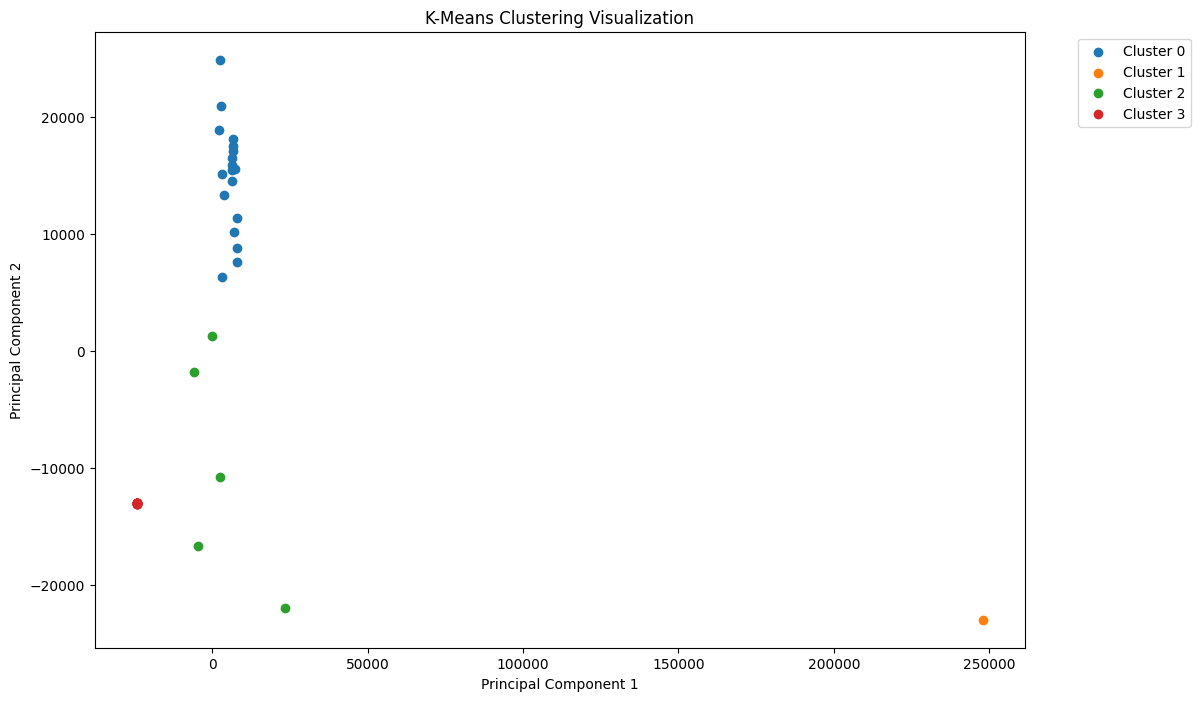

In [117]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the clusters
plt.figure(figsize=(12, 8))
for cluster in range(4):  # Adjust if you change n_clusters
    cluster_points = X_pca[kmeans.labels_ == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

plt.title("K-Means Clustering Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


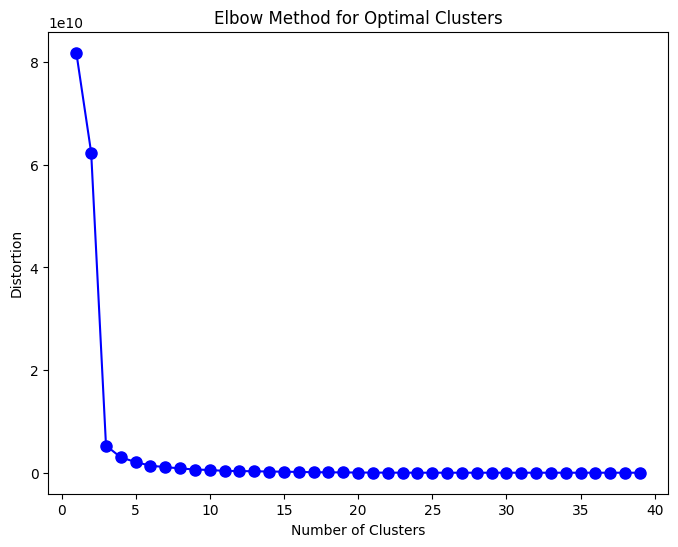

In [118]:
distortions = []
K = range(1, len(X) + 1)  # Test 1 to number of samples clusters
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K, distortions, 'bo-', markersize=8)
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Distortion")
plt.show()


In [109]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
